In [1]:
import xarray as xr
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf

from utils.plot_config import set_matplotlib_config, blend_legend_color_with_alpha

set_matplotlib_config()
SAVE_DIR = Path('../figures/')

In [2]:
eng = xr.open_zarr(
    '/net/argon/landclim/kraftb/machflow_engression/runs_timesplit/combined.zarr/'
).sel(beta=0.67, esl=5, nl=100).sel(time=slice('2017', '2022'))
eng = eng.where((eng.folds > 0).compute(), drop=True)[['Qmm', 'Qmm_mod']].compute()


In [3]:
from scipy.signal import welch

def compute_psd(signal, fs=1.0):
    freqs, psd = welch(signal, fs=fs, nperseg=min(len(signal) // 2, 256))
    return freqs, psd

In [4]:
eng_freqs, eng_psd = xr.apply_ufunc(
    compute_psd,
    eng,                                        # Observations with ["time"]
    input_core_dims=[['time']],               # Observations have no "quantile", quantiles do
    output_core_dims=[('frequency',), ('frequency',)],              # Output is scalar per observation
    # exclude_dims={'t'},
    vectorize=True,                     # Apply function element-wise
    dask="parallelized",                # Enable Dask parallelization if needed
    output_dtypes=[np.float32, np.float32],           # Output type
    # kwargs={'nlags': 40}
)

eng_psd['frequency'] = eng_freqs.Qmm.isel(station=0)
eng_psd = eng_psd.where(~eng_psd.Qmm.isnull().all('frequency'), drop=True)
eng_psd = eng_psd / eng_psd.Qmm.max(dim='frequency')

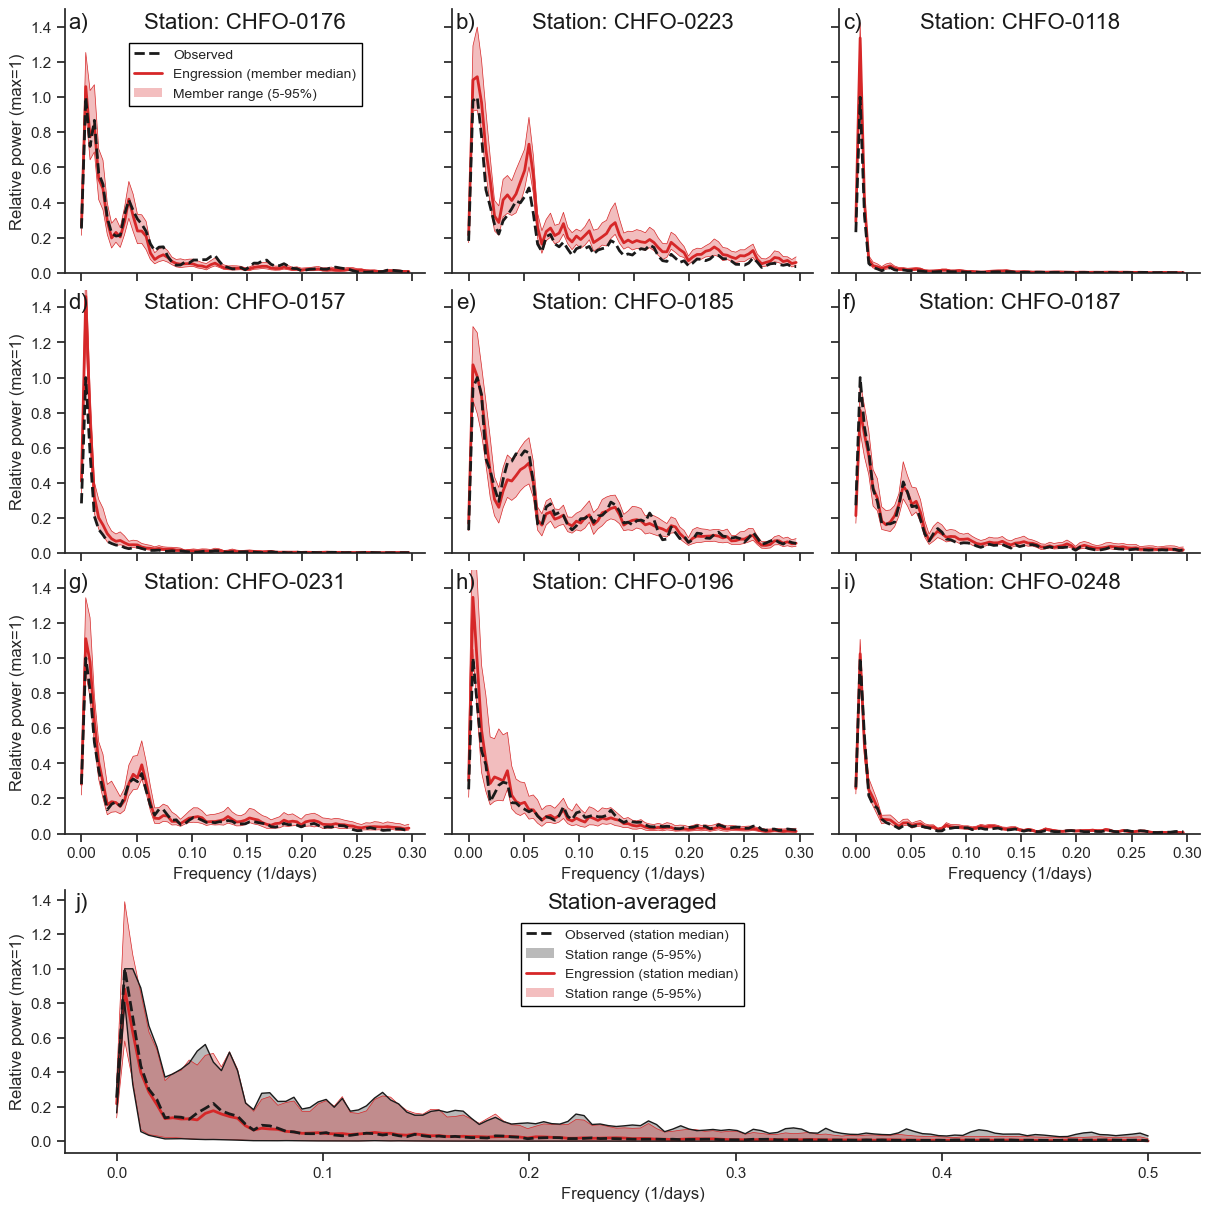

In [6]:
rs = np.random.RandomState(66)
stations = rs.permutation(eng_psd.station.values)[:9]

fig = plt.figure(figsize=(12, 12), constrained_layout=True)

gs = fig.add_gridspec(4, 3, wspace=0.0)

axes = [fig.add_subplot(gs[0, 0])]
for i in range(1, len(stations)):
    axes.append(fig.add_subplot(gs[i // 3, i % 3]))

axs = fig.add_subplot(gs[3, :])

for i, (station, ax) in enumerate(zip(stations, axes)):
    eng_psd_sel = eng_psd.sel(station=station, frequency=slice(0, 0.3))
    eng_psd_sel.Qmm.plot(color='k', lw=2, ls='--', add_legend=False, zorder=20, label='Observed', ax=ax);
    med = eng_psd_sel.Qmm_mod.median('member')
    low = eng_psd_sel.Qmm_mod.quantile(0.05, 'member')
    high = eng_psd_sel.Qmm_mod.quantile(0.95, 'member')

    med.plot(ax=ax, color='tab:red', lw=2, add_legend=False, label='Engression (member median)')
    low.plot(ax=ax, color='tab:red', lw=0.5, add_legend=False)
    high.plot(ax=ax, color='tab:red', lw=0.5, add_legend=False)

    ax.fill_between(
        x=eng_psd_sel.frequency, y1=low, y2=high, ec='none', fc='tab:red', alpha=0.3, zorder=-20,
        label='Member range (5-95%)')

    ax.set_title('')

    if i > len(stations) - 4:
        ax.set_xlabel('Frequency (1/days)')
    else:
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_xticklabels([])

    if i % 3 == 0:
        ax.set_ylabel('Relative power (max=1)')
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])

    ax.annotate(f'Station: {station}', xy=(0.5, 0.99), xycoords='axes fraction', fontsize=16,
            ha='center', va='top', color='k')
    ax.set_ylim(0, 1.5)

eng_psd_sel = eng_psd.sel(frequency=slice(0, 1.0))
med = eng_psd_sel.Qmm.median('station')
low = eng_psd_sel.Qmm.quantile(0.05, 'station')
high = eng_psd_sel.Qmm.quantile(0.95, 'station')

med.plot(ax=axs, color='k', lw=2, ls='--', add_legend=False, label='Observed (station median)', zorder=20)
low.plot(ax=axs, color='k', lw=1, add_legend=False, zorder=20)
high.plot(ax=axs, color='k', lw=1, add_legend=False, zorder=20)

axs.fill_between(
    x=eng_psd_sel.frequency, y1=low, y2=high, ec='none', fc='k', alpha=0.3, zorder=-20,
    label='Station range (5-95%)')

eng_psd_sel = eng_psd_sel.mean('member')
med = eng_psd_sel.Qmm_mod.median('station')
low = eng_psd_sel.Qmm_mod.quantile(0.05, 'station')
high = eng_psd_sel.Qmm_mod.quantile(0.95, 'station')

med.plot(ax=axs, color='tab:red', lw=2, add_legend=False, label='Engression (station median)', zorder=19)
low.plot(ax=axs, color='tab:red', lw=0.5, add_legend=False, zorder=19)
high.plot(ax=axs, color='tab:red', lw=0.5, add_legend=False, zorder=19)

axs.fill_between(
    x=eng_psd_sel.frequency, y1=low, y2=high, ec='none', fc='tab:red', alpha=0.3, zorder=-20,
    label='Station range (5-95%)')

axs.set_title('')
axs.set_xlabel('Frequency (1/days)')
axs.set_ylabel('Relative power (max=1)')
axs.annotate('Station-averaged', xy=(0.5, 0.99), xycoords='axes fraction', fontsize=16,
        ha='center', va='top', color='k')

legend = axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, 0.9))
blend_legend_color_with_alpha(legend=legend, indices=[2], alpha=0.3)
legend = axs.legend(loc='upper center', bbox_to_anchor=(0.5, 0.9))
blend_legend_color_with_alpha(legend=legend, indices=[1, 3], alpha=0.3)

for ax, label in zip(axes + [axs], range(ord('a'), ord('z')+1)[:len(stations) + 1]):
    ax.annotate(f'{chr(label)})', xy=(0.01, 0.99), xycoords='axes fraction', fontsize=16,
            ha='left', va='top', color='k')

    ax.spines[['top', 'right']].set_visible(False)
    ax.set_rasterization_zorder(-5)


fig.savefig(SAVE_DIR / 'power_spectrums.eps', dpi=250, bbox_inches='tight')

In [1]:
import numpy as np

In [3]:
np.digitize(1, [0, 1.1, 2])

1

In [ ]:
# 